# Scratch Pad

## Report

##### Overview
Before settling on my final model, I mainly explored using a convolution neural network (CNN) and a normal linear neural network. I thought of using a CNN as judging from the given data, we had to classify images and CNNs were supposedly better for that kind of data. Unfortunately, I could not tune my CNN well enough and got consistently low F1 scores. I then settled on using a linear model which was quicker and while inconsistent, still gave higher F1 scores overall. I mostly spent my time after that tuning the number of layers and the hyperparameters to make it more consistent and accurate.

##### 1. Descriptive Analysis
As suggested, I found the mean, median, mode, standard deviation and range of the data. Judging from the min and max values as well as the standard deviation, I realised there were quite a number of outliers that needed to be handled. The mode also showed a lot of 0s and 255s so i just assumed the intended range of values was 0 - 255.

##### 2. Detection and Handling of Missing Values
There were NaN values in the data which I replaced with the channel mean of the pixel's or value's respective channel in that image. I thought this was a good compromise as this would not skew the data while being easy to compute. I thought of using a more local mean for a more accurate representation by getting the mean of the values directly around the NaN value but decided against it due to efficiency reasons.

##### 3. Detection and Handling of Outliers
I found out that the outliers (values below 0 and above 255) made up around 2% of the data which was not insignificant. Thus, I replaced them with the channel mean the same as how the NaN values were handled for the same reason.

##### 4. Detection and Handling of Class Imbalance 
The classes were very imbalanced (2392, 203, 25) which made me decide to use cost-sensitive training as I felt that undersampling or oversampling would lose too much data or not provide a good representation of the data.

##### 5. Understanding Relationship Between Variables
I skipped this part. Considering the number of variables (768 if image flattened), I decided it was best to let PCA reduce dimensionality instead of manually doing it myself.

##### 6. Data Visualization
I also skipped this part for the same reason above.

##### 7. General Preprocessing
- I preprocessed the data by first replacing the outliers with NaN values since I was going to be treating both the same by replacing them with their channel mean.
- I went through all the data replacing NaN values with their channel mean.
- I flattened the images and standardised them by using sklearn's StandardScaler to prepare them for PCA. I used MinMaxScaler at first but found out that since I technically already normalised the range by eliminating outliers, the StandardScaler should technically work better. In practice there was minimal improvement if at all.
 
##### 8. Feature Selection 
I used sklearn's PCA to reduce dimensionality and thus noise. For the number of components I chose 0.99 which will result in a calculated number of components to retain until they collectively explain at least 99% of the variance in the original data. This was a conservative option as it reduced the number of components to around 600 most of the time. I experimented using 0.95 or 95% variance but there was noticeable deprovements in accuracy so I stuck with 0.99.

##### 9. Feature Engineering
I skipped this part as I wanted to keep it simple at first and ended up having no time to try this.

##### 10. Creating Models
I initially used 1 hidden linear layer with 256 or 128 parameters which on average gave me around a 0.5 F1 score. I also used CrossEntropyLoss as it allowed inputting custom weights to handle the class imbalance. I also used sklearn's class_weight compute to help me compute a balanced distribution which I could pass to the loss function to use. For the optimiser, I settled on Adam as it usually provided the best accuracy as opposed to Adagrad or SGD. Learning rate is 1e-3 which is standard but also worked well with the smaller batch numbers that I found provided more consistent results. I toyed with batch numbers up to 512 but settled with 64 and 128 as they proved more consistent. I also added more hidden layers and settled on 3 as I found it provided consistently better accuracy without too much of a hit on performance. The parameters I used were 1024, 512 and 256.

##### 11. Model Evaluation
I mostly just went by loss and testing using the F1 score provided in the main jupyter notebook as I did not have much time to set up my own testing suite.

##### 12. Hyperparameters Search
I skipped this as I had no time so I just randomly changed things that somewhat made sense like learning rate and batch size.

##### Conclusion
To conclude, while my model is not conventionally used for image classification, it's performance was satisfactory and it was easily tunable and generalisable which is good.

---

# Workings (Not Graded)

You will do your working below. Note that anything below this section will not be graded, but we might counter-check what you wrote in the report above with your workings to make sure that you actually did what you claimed to have done. 

## Import Packages

Here, we import some packages necessary to run this notebook. In addition, you may import other packages as well. Do note that when submitting your model, you may only use packages that are available in Coursemology (see `main.ipynb`).

In [92]:
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Load Dataset

The dataset `data/images.npy` is of size $(N, C, H, W)$, where $N$, $C$, $H$, and $W$ correspond to the number of data, image channels, image width, and image height, respectively.

A code snippet that loads the data is provided below.

### Load Image Data

In [93]:
with open('data.npy', 'rb') as f:
    data = np.load(f, allow_pickle=True).item()
    images = data['image']
    labels = data['label']
    
print('Shape:', images.shape)

Shape: (2911, 3, 16, 16)


In [94]:
print(images.dtype)
print(np.unique(labels, return_counts=True))

print(np.nanmin(images), np.nanmax(images))

#print(images[1])

nonnan = np.count_nonzero(~np.isnan(images))
nan = np.count_nonzero(np.isnan(images))
print(nan / (nonnan + nan) * 100, '%')


float16
(array([ 0.,  1.,  2., nan], dtype=float16), array([2392,  203,   25,  291]))
-10000.0 10000.0
0.98016324573457 %


## Data Exploration & Preparation

### 1. Descriptive Analysis

In [95]:
# Descriptive Analysis
data_summary = {
    'Mean': np.nanmean(images.astype('float64'), dtype=np.float64),
    'Median': np.nanmedian(images),
    'Mode': stats.mode(images, nan_policy='omit').mode[0],
    'Range': np.nanmax(images) - np.nanmin(images),
    'Standard Deviation': np.nanstd(images.astype('float64'), dtype=np.float64),
    'Variance': np.nanvar(images.astype('float64'), dtype=np.float64),
    'Interquartile Range': np.nanpercentile(images, 75) - np.nanpercentile(images, 25)
}

print("Descriptive Analysis:")
for key, value in data_summary.items():
    print(f"{key}: {value}")


Descriptive Analysis:
Mean: 91.95161440252559
Median: 78.0
Range: 20000.0
Standard Deviation: 823.0422541579951
Variance: 677398.5521294738
Interquartile Range: 93.875


### 2. Detection and Handling of Missing Values

In [97]:
print(np.count_nonzero(np.isnan(images)))

for i in range(images.shape[0]):
    # Extract the current image
    image = images[i, :, :, :]

    # Check if there are any NaN values in the image
    if np.isnan(image).any():
        # Calculate the mean value of each channel
        channel_means = np.nanmean(image.astype('float64'), axis=(1, 2))
        if np.isnan(channel_means).any():
            print("There are NaN values in the channel means")

        # Replace NaN values with the corresponding channel mean
        image[0][np.isnan(image[0])] = channel_means[0]
        image[1][np.isnan(image[1])] = channel_means[1]
        image[2][np.isnan(image[2])] = channel_means[2]

    # Put the resolved image back into the image array
    images[i, :, :, :] = image

print(np.count_nonzero(np.isnan(images)))

21913
0


### 3. Detection and Handling of Outliers

In [96]:
above = (images > 255).sum()
print(above / (images.size) * 100, '%')
below = (images < 0).sum()
print(below / (images.size) * 100, '%')

print(stats.mode(images[images > 255], nan_policy='omit'))

np.clip(images, 0, 255, out=images)
print((images > 255).sum())
print((images < 0).sum())

0.9826681123325317 %
0.9975631226382685 %
ModeResult(mode=8880.0, count=32)
0
0


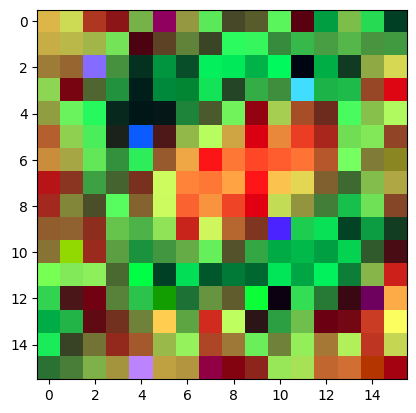

In [77]:
plt.imshow(images[2200].astype('int').T)

### 4. Detection and Handling of Class Imbalance

In [78]:
print(np.unique(labels, return_counts=True))

(array([ 0.,  1.,  2., nan], dtype=float16), array([2392,  203,   25,  291]))


In [79]:
unq, count = np.unique(images, axis=0, return_counts=True)
print(images[count > 1])

[]


## Data Preprocessing

### 5. Feature Engineering

In [98]:
print(np.count_nonzero(np.isnan(images)))
reshaped = images.reshape(images.shape[0], -1)
scaler = StandardScaler()
reshaped_scaled = scaler.fit_transform(reshaped)

pca = PCA(n_components=0.99)
pca.fit(reshaped_scaled)
print(pca.noise_variance_)
print(pca.n_components_)
print(pca.n_features_)
print(pca.n_samples_)


0
0.003041129403455104
645
768
2911


In [104]:
reshaped_scaled = pca.transform(reshaped_scaled)

## Modeling & Evaluation

### 6. Creating models

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

In [105]:
# remove nan values from labels and data
reshaped_scaled = reshaped_scaled[~np.isnan(labels)]
labels = labels[~np.isnan(labels)]

In [106]:
print(np.unique(labels))
print(reshaped_scaled.shape)

[0. 1. 2.]
(2620, 645)


In [114]:
class CNNModel(nn.Module):  
    """
    This class represents an AI model.
    """
    def __init__(self):
        """
        Constructor for Model class.
  
        Parameters
        ----------
        self : object
            The instance of the object passed by Python.
        """
        super(CNNModel, self).__init__()
        self.conv = nn.Sequential(
                        nn.Conv2d(3, 32, (3,3)),
                        nn.MaxPool2d((2, 2)),
                        nn.LeakyReLU(0.1),
                        nn.Conv2d(32, 64, (3,3)),
                        nn.MaxPool2d((2, 2)),
                        nn.LeakyReLU(0.1)
                    )

        self.fc = nn.Sequential(
                        nn.Linear(64, 256),
                        nn.LeakyReLU(0.1),
                        nn.Linear(256, 128),
                        nn.LeakyReLU(0.1),
                        nn.Linear(128, 3)
                    )

    def forward(self, x):
        x = self.conv(x)
        #x = x.view(x.shape[0], 32, 4).mean(2) # GAP – do not remove this line
        x = nn.AvgPool2d(x.shape[2:])(x).view(x.shape[0], -1)
        x = self.fc(x)

        return x
    
    def preprocess(self, X):
        # Normalize the data by replacing outliers with NaN
        X[X > 255] = np.nan
        X[X < 0] = np.nan

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
            #transforms.RandomRotation(45)
        ])

        # Replace NaN values with the mean of the channel
        for i in range(X.shape[0]):
            image = X[i, :, :, :]

            if np.isnan(image).any():
                channel_means = np.nanmean(image.astype('float64'), axis=(1, 2))
                if np.isnan(channel_means).any():
                    print("There are NaN values in the channel means")

                image[0][np.isnan(image[0])] = channel_means[0]
                image[1][np.isnan(image[1])] = channel_means[1]
                image[2][np.isnan(image[2])] = channel_means[2]

            img_transposed = np.transpose(image, (1, 2, 0))
            img_transformed = transform(img_transposed)
            test = np.transpose(img_transformed, (0, 1, 2))
            X[i, :, :, :] = test

        return X
    
    def scale(self, X):
        # Reshape and scale the data
        reshaped = X.reshape(X.shape[0], -1)
        scaler = StandardScaler()
        reshaped_scaled = scaler.fit_transform(reshaped)

        return reshaped_scaled


    def fit(self, X, y):
        """
        Train the model using the input data.
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, channel, height, width)
            Training data.
        y : ndarray of shape (n_samples,)
            Target values.
            
        Returns
        -------
        self : object
            Returns an instance of the trained model.
        """
        X = self.preprocess(X)
        #X = self.scale(X)

        # Apply PCA
        #self.pca = PCA(n_components=0.99)
        #self.pca.fit(X)
        # Define the fc1 using the number of components from PCA
        #self.fc1 = nn.Linear(self.pca.n_components_, self.n_hidden1)
        #X_pca = self.pca.transform(X)

        # Remove data with a corresponding NaN value in y
        X = X[~np.isnan(y)]
        y = y[~np.isnan(y)]

        # Calculate class weights for imbalanced data
        class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
        class_weights = torch.tensor(class_weights, dtype=torch.float)

        # Convert to tensors
        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).long()

        # Initialize dataloader
        train_loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=512)

        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss(class_weights)

        # Train the model
        num_epochs = 200
        #prev_loss = 99999
        for i in range(num_epochs):
            epoch_loss = 0
            for _, data in enumerate(train_loader):
                inputs, labels = data
                outputs = self(inputs)
                loss = loss_fn(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                #if loss.item() > prev_loss:
                #    break
                #prev_loss = loss.item()

                epoch_loss += loss.item()

            epoch_loss = epoch_loss / len(train_loader)
            print ("Epoch: {}, Loss: {}".format(i, epoch_loss))
    
    def predict(self, X):
        """
        Use the trained model to make predictions.
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, channel, height, width)
            Input data.
            
        Returns
        -------
        ndarray of shape (n_samples,)
        Predicted target values per element in X.
           
        """
        self.eval()
        #X = self.preprocess(X)
        #X = self.scale(X)
        #X = self.pca.transform(X)
        X = torch.from_numpy(X).float()
        with torch.no_grad():
            outputs = self(X)

        return torch.argmax(outputs, dim=1).numpy()

Epoch [1/100], Loss: 1.1078
Epoch [2/100], Loss: 1.0667
Epoch [3/100], Loss: 1.0301
Epoch [4/100], Loss: 0.9965
Epoch [5/100], Loss: 0.9650
Epoch [6/100], Loss: 0.9350
Epoch [7/100], Loss: 0.9060
Epoch [8/100], Loss: 0.8773
Epoch [9/100], Loss: 0.8488
Epoch [10/100], Loss: 0.8206
Epoch [11/100], Loss: 0.7926
Epoch [12/100], Loss: 0.7650
Epoch [13/100], Loss: 0.7379
Epoch [14/100], Loss: 0.7115
Epoch [15/100], Loss: 0.6859
Epoch [16/100], Loss: 0.6611
Epoch [17/100], Loss: 0.6374
Epoch [18/100], Loss: 0.6146
Epoch [19/100], Loss: 0.5927
Epoch [20/100], Loss: 0.5718
Epoch [21/100], Loss: 0.5517
Epoch [22/100], Loss: 0.5324
Epoch [23/100], Loss: 0.5138
Epoch [24/100], Loss: 0.4958
Epoch [25/100], Loss: 0.4784
Epoch [26/100], Loss: 0.4616
Epoch [27/100], Loss: 0.4452
Epoch [28/100], Loss: 0.4294
Epoch [29/100], Loss: 0.4141
Epoch [30/100], Loss: 0.3993
Epoch [31/100], Loss: 0.3850
Epoch [32/100], Loss: 0.3712
Epoch [33/100], Loss: 0.3578
Epoch [34/100], Loss: 0.3448
Epoch [35/100], Loss: 0

In [ ]:
class MLPModel(nn.Module):  
    """
    This class represents an AI model.
    """
    def __init__(self):
        """
        Constructor for Model class.
  
        Parameters
        ----------
        self : object
            The instance of the object passed by Python.
        """
        super(MLPModel, self).__init__()
        self.lrelu = nn.LeakyReLU(0.1)
        self.n_hidden1 = 1024
        self.n_hidden2 = 512
        self.n_hidden3 = 256
        self.n_classes = 3
        self.fc2 = nn.Linear(self.n_hidden1, self.n_hidden2)
        self.fc3 = nn.Linear(self.n_hidden2, self.n_hidden3)
        self.fc4 = nn.Linear(self.n_hidden3, self.n_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.lrelu(x)
        x = self.fc2(x)
        x = self.lrelu(x)
        x = self.fc3(x)
        x = self.lrelu(x)
        x = self.fc4(x)

        return x
    
    def preprocess(self, X):
        # Normalize the data by replacing outliers with NaN
        X[X > 255] = np.nan
        X[X < 0] = np.nan

        # Replace NaN values with the mean of the channel
        for i in range(X.shape[0]):
            image = X[i, :, :, :]

            if np.isnan(image).any():
                channel_means = np.nanmean(image.astype('float64'), axis=(1, 2))
                if np.isnan(channel_means).any():
                    print("There are NaN values in the channel means")

                image[0][np.isnan(image[0])] = channel_means[0]
                image[1][np.isnan(image[1])] = channel_means[1]
                image[2][np.isnan(image[2])] = channel_means[2]

            X[i, :, :, :] = image

        return X
    
    def scale(self, X):
        # Reshape and scale the data
        reshaped = X.reshape(X.shape[0], -1)
        scaler = StandardScaler()
        reshaped_scaled = scaler.fit_transform(reshaped)

        return reshaped_scaled


    def fit(self, X, y):
        """
        Train the model using the input data.
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, channel, height, width)
            Training data.
        y : ndarray of shape (n_samples,)
            Target values.
            
        Returns
        -------
        self : object
            Returns an instance of the trained model.
        """
        X = self.preprocess(X)
        X = self.scale(X)

        # Apply PCA
        self.pca = PCA(n_components=0.99)
        self.pca.fit(X)
        # Define the fc1 using the number of components from PCA
        self.fc1 = nn.Linear(self.pca.n_components_, self.n_hidden1)
        X_pca = self.pca.transform(X)

        # Remove data with a corresponding NaN value in y
        X_pca = X_pca[~np.isnan(y)]
        y = y[~np.isnan(y)]

        # Calculate class weights for imbalanced data
        class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
        class_weights = torch.tensor(class_weights, dtype=torch.float)

        # Convert to tensors
        X = torch.from_numpy(X_pca).float()
        y = torch.from_numpy(y).long()

        # Initialize dataloader
        train_loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=64)

        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss(class_weights)

        # Train the model
        num_epochs = 200
        for i in range(num_epochs):
            epoch_loss = 0
            for _, data in enumerate(train_loader):
                inputs, labels = data
                outputs = self(inputs)
                loss = loss_fn(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            epoch_loss = epoch_loss / len(train_loader)
            print ("Epoch: {}, Loss: {}".format(i, epoch_loss))
    
    def predict(self, X):
        """
        Use the trained model to make predictions.
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, channel, height, width)
            Input data.
            
        Returns
        -------
        ndarray of shape (n_samples,)
        Predicted target values per element in X.
           
        """
        self.eval()
        X = self.preprocess(X)
        X = self.scale(X)
        X = self.pca.transform(X)
        X = torch.from_numpy(X).float()
        with torch.no_grad():
            outputs = self(X)

        return torch.argmax(outputs, dim=1).numpy()
    